# Memory In LangGraph


A very important feature of agentic system is remembering past chat history. 

LangGraph provides several ways of doing so - both in runtime memory and databases. 

We will explore both options, while also studying useful practises to avoid clogging message history with two many messages.

----
References:
- https://langchain-ai.github.io/langgraph/how-tos/memory/add-memory/
- https://langchain-ai.github.io/langgraph/concepts/persistence/#persistence
- https://github.com/langchain-ai/langchain-academy/tree/main/module-2

----

## 1. Short Term Memory

The easiest way to add memory to your LangGraph project is by using `InMemorySaver`. 

In order to do so, we just need to 

1. instantiate an instance of `InMemorySaver()` and then pass it as the `checkpointer` param in `.compile()`;
2. Pass a `thread_id` in graph config, which allows us to identify which conversation we are accessing. 

So let's use the checkpointer first:

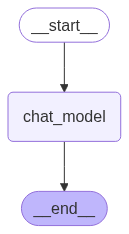

In [10]:
from langgraph.checkpoint.memory import InMemorySaver

from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

from langchain_openai import ChatOpenAI
from dotenv import load_dotenv

checkpointer = InMemorySaver()

# llm
load_dotenv("envs/.env")
llm = ChatOpenAI(model="gpt-4o")

# Node
def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile(checkpointer=checkpointer)

# View
display(Image(graph.get_graph().draw_mermaid_png()))


And then we pass a thread id at graph invocation: 

In [11]:
from langchain_core.messages import HumanMessage

input_state = {"messages": [HumanMessage(content="Hello, I am Matteo.")]}

In [12]:
result= graph.invoke(input_state, config={"configurable" : {"thread_id" : 1}})
for m in result['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello, I am Matteo.
================================== Ai Message ==================================

Hello, Matteo! How can I assist you today?


Will it remember who I am?

In [13]:
result= graph.invoke(
    input=
    {
        "messages": [HumanMessage(content="Hello, what is my name?")]
    },
    config=
    {
        "configurable" : {"thread_id" : 1}
    }
)
for m in result['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello, I am Matteo.
================================== Ai Message ==================================

Hello, Matteo! How can I assist you today?
================================ Human Message =================================

Hello, what is my name?
================================== Ai Message ==================================

You mentioned that your name is Matteo. How can I help you today?


Super easy right?

## 2. Long Term Memory



What if we want our Chatbot to have memory that persists indefinitely?

Now, we'll introduce some [more advanced checkpointers](https://langchain-ai.github.io/langgraph/how-tos/memory/add-memory/#use-in-production) that support external databases.

A good starting point here is the SqliteSaver checkpointer. Sqlite is a small, fast, highly popular SQL database.

In [14]:
%pip install --quiet -U langgraph-checkpoint-sqlite

Note: you may need to restart the kernel to use updated packages.


If we supply `":memory:"` it creates an in-memory Sqlite database.

In [15]:
import sqlite3
# In memory
conn = sqlite3.connect(":memory:", check_same_thread = False)


But, if we supply a db path, then it will create a database for us!

In [16]:
# Here is our checkpointer 
from langgraph.checkpoint.sqlite import SqliteSaver  # sync saver

# Create a checkpoint saver that uses SQLite
conn = sqlite3.connect("example_db/checkpoints.db", check_same_thread=False)
longterm_memory = SqliteSaver(conn)

> **Note:** if you already had a database and wanted to use the existing one: 
>
>```python
>conn = sqlite3.connect(<db_path>, check_same_thread=False)
>memory = SqliteSaver(conn)
>```

Now, we just re-compile with our sqlite checkpointer.

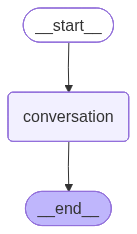

In [17]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START

# Define a new graph
workflow = StateGraph(MessagesState)
workflow.add_node("conversation", chat_model_node)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_edge("conversation", END)

# Compile
graph = workflow.compile(checkpointer=longterm_memory)
display(Image(graph.get_graph().draw_mermaid_png()))

Now, we can invoke the graph several times.

In [18]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Matteo")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="I am a researcher :)")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Hello again, Matteo! How can I assist you today?
================================== Ai Message ==================================

You mentioned that your name is Matteo. How can I help you today?
================================== Ai Message ==================================

That's wonderful, Matteo! What area do you specialize in for your research?


## 3. Memory Management

Mmeory is great, but tokens are expensive. What if our model builds up a chat history of hundred of thousands of token? 

This would both slow down our model, and rip a whole in our wallet at each run.

Luckily we have several ways to manage that.

### 3.1 Using `RemoveMessage` 

One way of filtering input messages from chat history is by using the `RemoveMessage` object. 

This works when using the `MessagesState` class - i.e., almost in every application, at least if we want our model to have a chatbot-like structure.  

It works with messages state because it leverages the reducer `add_messages`, which is built in in `MessagesState`.
Specifically, we need to combine our reducer with the `id` parameter that we can specify in messages.

#### Message id

The `id` field can be used to both **rewrite** messages or delete messages. 

**To rewrite:**

If we pass a message with the same ID as an existing one in our messages list, it will get overwritten!

In [19]:
from langgraph.graph.message import add_messages
from langchain_core.messages import AIMessage, HumanMessage

# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model", id="1"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance", id="2")
                   ]

# New message to add
new_message = HumanMessage(content="I'm looking for information on whales, specifically", name="Lance", id="2")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='1'),
 HumanMessage(content="I'm looking for information on whales, specifically", additional_kwargs={}, response_metadata={}, name='Lance', id='2')]

**To remove:**

we simply use [`RemoveMessage`](https://python.langchain.com/api_reference/core/messages/langchain_core.messages.modifier.RemoveMessage.html#removemessage) from `langchain_core`

In [20]:
from langchain_core.messages import RemoveMessage

# Message list
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))

# Isolate messages to delete
delete_messages = [RemoveMessage(id=ids) for ids in [3, 4]]
print(delete_messages)

[RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='3'), RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='4')]


In [21]:
add_messages(messages , delete_messages)

[AIMessage(content='Hi.', additional_kwargs={}, response_metadata={}, name='Bot', id='1'),
 HumanMessage(content='Hi.', additional_kwargs={}, response_metadata={}, name='Lance', id='2')]

We can see that message IDs 3 and 4, as noted in `delete_messages` are removed by the reducer.

So, we can use this in order to *remove specific messages from memory*, based on their id. 

### 3.2 Filtering/Trimming messages

The most basic approach - and probably the least useful - is just to *filter* the the input messages list, like 

```python
messages = messages[-3]    # keep only last 3 messages, blindly

If we want a more thoughtful approach, we can [**trim**](https://python.langchain.com/v0.2/docs/how_to/trim_messages/#getting-the-last-max_tokens-tokens) messages based on input tokens:

While filtering only returns a post-hoc subset of the messages between agents, trimming restricts the number of tokens that a chat model can use to respond.

In [22]:
from langchain_core.messages import trim_messages
from langgraph.graph import MessagesState, StateGraph, START, END

# Node
def chat_model_node(state: MessagesState):
    messages = trim_messages(
            state["messages"],
            max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=False,
        )
    return {"messages": [llm.invoke(messages)]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

In [36]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

It's great that you're interested in ocean mammals! In addition to whales, here are some other marine mammals you might want to learn about:

1. **Dolphins**: These are highly intelligent and social animals known for their playful behavior. There are various species of dolphins, such as the bottlenose dolphin and the common dolphin.

2. **Porpoises**: Similar to dolphins but generally smaller, porpoises have distinct diffe

In [37]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me where Orcas live!", name="Lance"))

In [ ]:
# Example of trimming messages
trim_messages(
            messages,
            max_tokens=200, # only last 200 tokens
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=True  # allows messages to be split 
        )

[AIMessage(content="\n3. **North Pacific Ocean**: Populations are found along the coasts of Alaska, British Columbia, Washington State, and down to California. They are also present in the waters around Japan and Russia's Far East.\n\n4. **Southern Ocean**: Orcas are present around the continent of Antarctica, where they hunt seals and other marine life.\n\n5. **Temperate and Tropical Regions**: While less common, orcas can also be found in warmer waters, including parts of the Indian Ocean and around islands like the Galápagos and Hawaii.\n\nOrcas are social animals often seen in groups, and different populations have distinct dietary preferences and hunting techniques. Their adaptability enables them to exploit a wide range of marine environments.", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 264, 'prompt_tokens': 16, 'total_tokens': 280, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_token

Check out the `trim_message` doc: https://python.langchain.com/v0.2/docs/how_to/trim_messages/#getting-the-last-max_tokens-tokens

It has many useful parameters for custom trimming.

It comes very handy when managing memory in order to not exceed a certain token count.

### 3.3 llm-Based Summarization

Another interesting "trick" to manage memory is to use an llm to summarize chat history. 

We just need to add a summarization node to our graph in the beginning, specifying a condition under which input messages should be summarized. For example, messages exceeding a certain token count, or simply after a certain number of messages.

In [39]:
from langgraph.graph import MessagesState
class State(MessagesState):
    summary: str

In [48]:
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4o")

# Define the logic to call the model
def call_model(state: State):
    
    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = model.invoke(messages)
    return {"messages": response}

Note, here we'll use `RemoveMessage` to filter our state after we've produced the summary.

In [49]:
def summarize_conversation(state: State):
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

We'll add a conditional edge to determine whether to produce a summary based on the conversation length.

For simplicity here let's summarize after we hit 3 messages

In [50]:
from langgraph.graph import END
from typing_extensions import Literal
# Determine whether to end or summarize the conversation
def should_continue(state: State) -> Literal ["summarize_conversation",END]:
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 3:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END

We add runtime memory (we could as well do it with long term memory as we saw before)

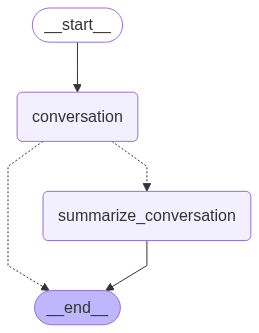

In [51]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [52]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Matteo")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="i like physics!")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="I am a researcher!")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Hello, Matteo! How can I assist you today?
================================== Ai Message ==================================

You mentioned that your name is Matteo. How can I help you further?
================================== Ai Message ==================================

That's great to hear! Physics is a fascinating subject that explores the fundamental principles governing the universe. Do you have any specific areas of interest within physics, or any questions you might have?
================================== Ai Message ==================================

That's impressive! Being a researcher in physics means you're at the forefront of discovering and understanding the natural world. What area of physics are you focusing on in your research?


In [53]:
graph.get_state(config).values.get("summary","")

"Matteo shared that he is a researcher, indicating his involvement in advancing knowledge within the field of physics. The assistant acknowledged Matteo's role as a researcher and expressed interest in his specific area of focus within physics, highlighting the exciting nature of working on the cutting edge of scientific discovery."